## Does ensemble work best step-wise or trajectory-wise?

In [1]:
import h5py
import torch
import numpy as np
import matplotlib.pyplot as plt

# with h5py.File(f'data_large/Burgers_train_100000_default.h5', 'r') as f:
#     # Traj_dataset.traj_train = torch.tensor(f['train']['pde_140-256'][:10000, :131], dtype=torch.float32, device=cfg.device)
#     traj = torch.tensor(f['train']['pde_140-256'][:1000, :131], dtype=torch.float32)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [2]:
import hydra
from omegaconf import DictConfig, OmegaConf
from generate_data import generate_timestep
from tqdm import tqdm

hydra.initialize(config_path="cfg_long_hal", version_base=None)
cfg = hydra.compose(config_name="config", overrides=["task=Heat", "nt=14"])

from utils import set_seed
set_seed(100)

In [3]:
with h5py.File(cfg.dataset.train_path, 'r') as f:
    # Traj_dataset.traj_train = torch.tensor(f['train']['pde_140-256'][:10000, :131], dtype=torch.float32, device=cfg.device)
    traj = torch.tensor(f['train']['pde_140-256'][:1000, :131], dtype=torch.float32)

In [4]:
from neuralop.models import FNO

unrolling = cfg.train.unrolling
nt = cfg.nt
ensemble_size = cfg.ensemble_size
num_acquire = cfg.num_acquire
device = cfg.device
epochs = cfg.train.epochs
lr = cfg.train.lr
batch_size = cfg.train.batch_size
initial_datasize = cfg.initial_datasize

def train(Y, train_nts, **kwargs):
    model = FNO(n_modes=(256, ), hidden_channels=64,
                in_channels=1, out_channels=1)

    model = model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs)
    criterion = torch.nn.MSELoss()

    inputs = []
    outputs = []
    for b in range(Y.shape[0]):
        for t in range(train_nts[b].item()-1):
            inputs.append(Y[b,t])
            outputs.append(Y[b, t+1])
    inputs = torch.stack(inputs, dim=0).unsqueeze(1)
    outputs = torch.stack(outputs, dim=0).unsqueeze(1)

    dataset = torch.utils.data.TensorDataset(inputs, outputs)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

    model.train()
    for epoch in range(epochs):
        model.train()
        # max_unrolling = epoch if epoch <= unrolling else unrolling
        # unrolling_list = [r for r in range(max_unrolling + 1)]

        total_loss = 0
        for x, y in dataloader:
            optimizer.zero_grad()
            x, y = x.to(device), y.to(device)
            
            pred = model(x)
            loss = criterion(pred, y)

            # loss = torch.sqrt(loss)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        scheduler.step()
        # wandb.log({f'train/loss_{acquire_step}': total_loss})
    return model

timestep = (traj.shape[1] - 1) // (nt - 1) # 10
Y = traj[:,0::timestep]
train_nts = torch.ones(Y.shape[0], device=device, dtype=torch.int64)
train_nts[:initial_datasize] = nt

ensemble = [train(Y, train_nts) for _ in range(ensemble_size)]

In [5]:
from utils import torch_expand
from eval_utils import compute_metrics

test_Y = traj[initial_datasize:1000, 0::timestep]

for model in ensemble:
    model.eval()

preds = []
preds.append(torch_expand(test_Y[None,:,0:1], dim=0, copies=ensemble_size)) # ensemble_size x batch x 1 x 256

with torch.no_grad():
    for t in range(nt-1):
        X = preds[-1].to(device)
        pred = torch.stack([model(X[i]) for i, model in enumerate(ensemble)], dim=0) # ensemble_size x batch x 1 x 256
        preds.append(pred.cpu())

preds = torch.stack(preds, dim=1) # batch x nt x 256
pred = preds.mean(dim=0)
pred = pred.squeeze(2).permute(1,0,2) # batch x nt x 256

metrics = compute_metrics(test_Y, pred, d=2, device=device, reduction=True)

print(metrics)

(tensor(0.0086), tensor(0.0034), tensor(0.0564))


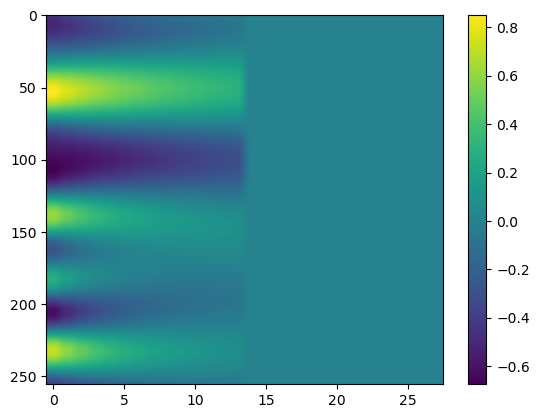

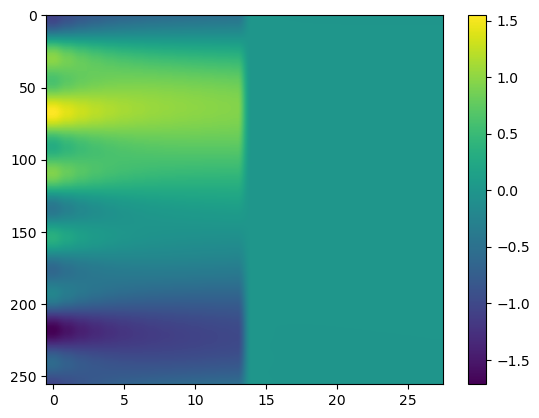

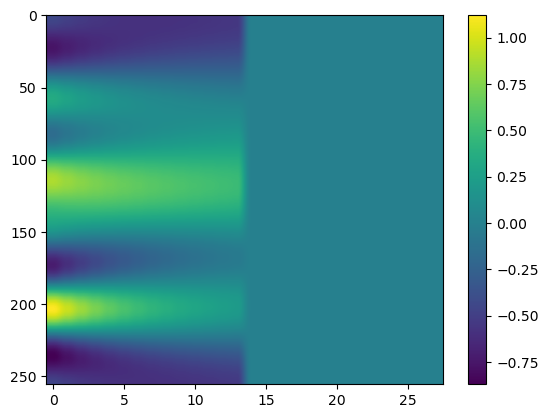

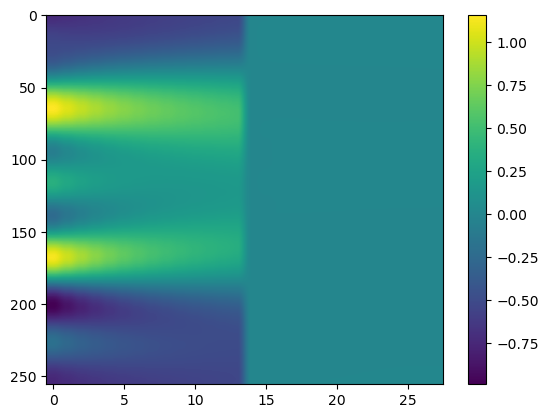

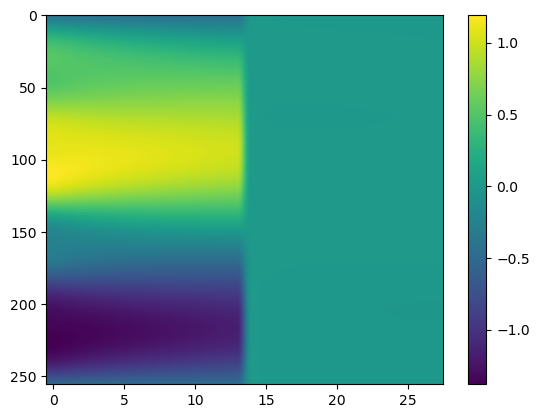

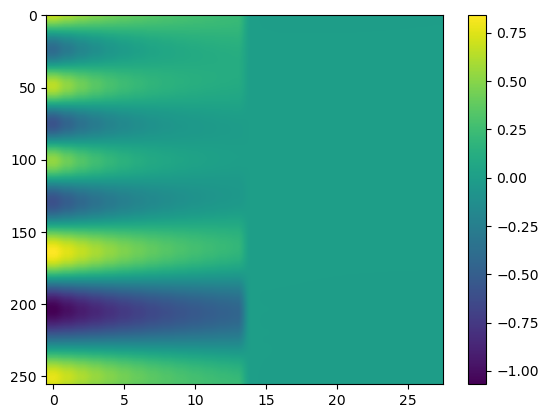

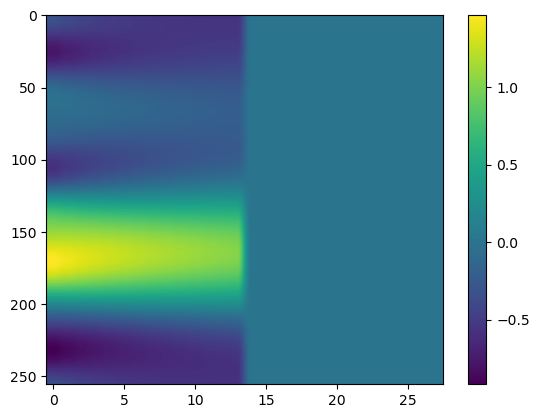

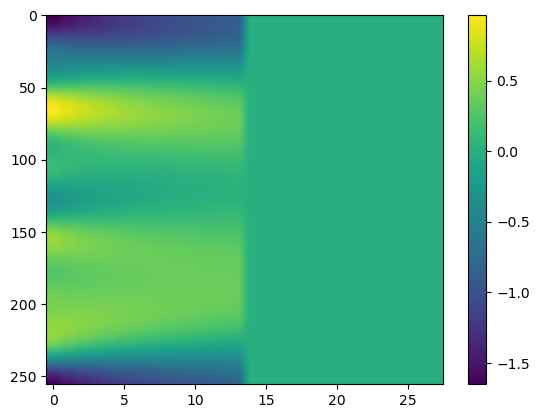

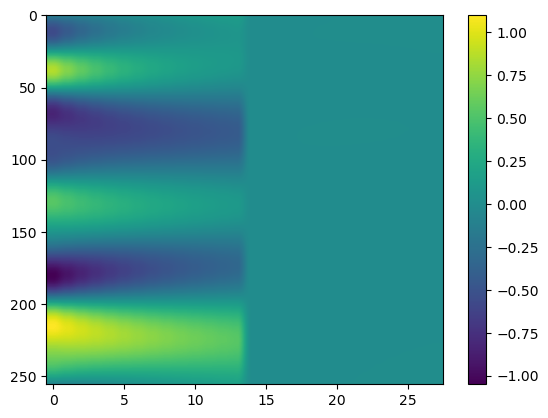

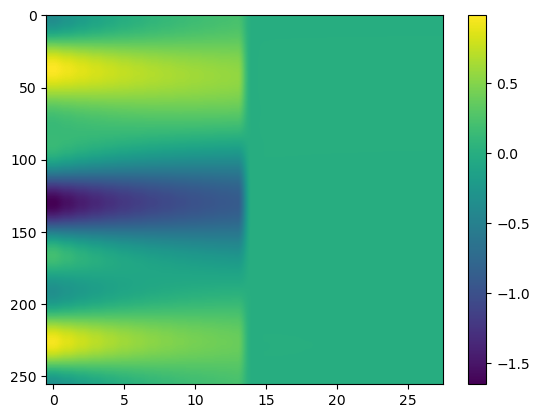

In [6]:
for idx in range(10):
    plt.figure()
    plt.imshow(torch.cat([test_Y[idx].T, test_Y[idx].T - pred[idx].T], dim=1), aspect='auto')
    plt.colorbar()

# plt.figure()
# plt.imshow(, aspect='auto')
# plt.colorbar()

In [7]:
from utils import torch_expand

test_Y = traj[initial_datasize:1000, 0::timestep]

for model in ensemble:
    model.eval()

preds = []
preds.append(test_Y[:,0:1]) # ensemble_size x batch x 1 x 256

with torch.no_grad():
    for t in range(nt-1):
        X = preds[-1].to(device)
        pred = torch.stack([model(X) for model in ensemble], dim=0) # ensemble_size x batch x 1 x 256
        preds.append(pred.mean(0).cpu()) # batch x 1 x 256


preds = torch.cat(preds, dim=1) # batch x nt x 256
pred = preds.cpu()

metrics = compute_metrics(test_Y, pred, d=2, device=device, reduction=True)

print(metrics)

(tensor(0.0086), tensor(0.0034), tensor(0.0576))


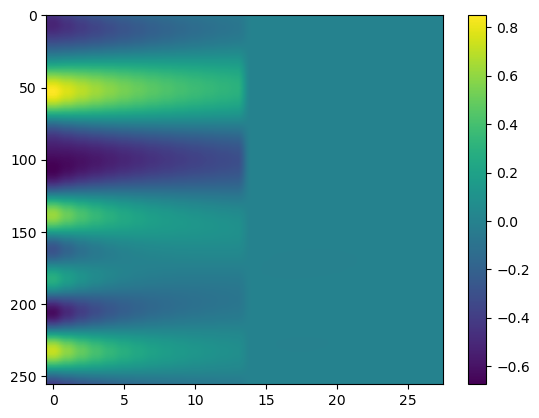

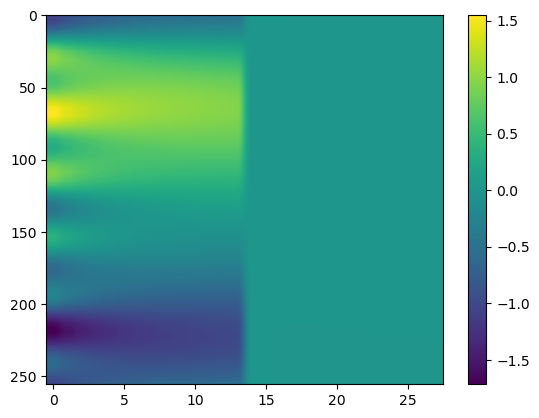

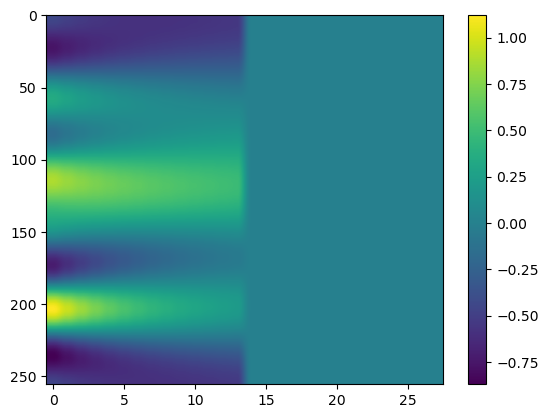

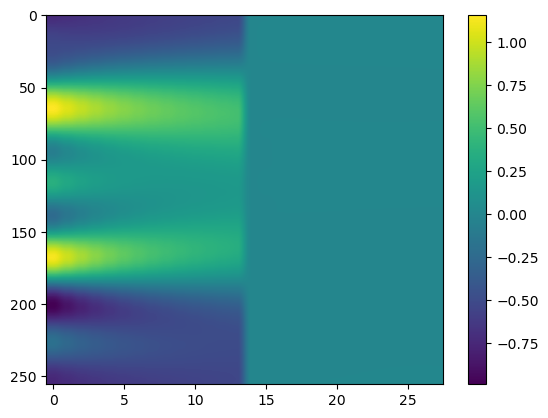

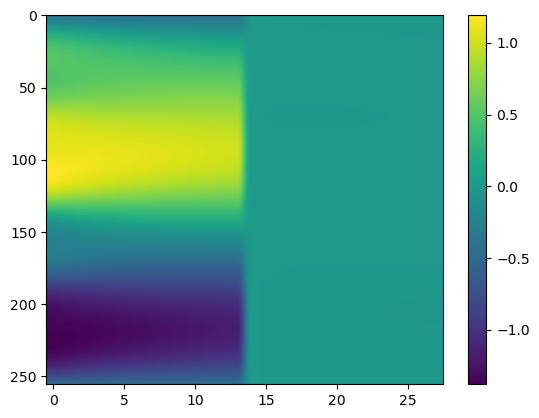

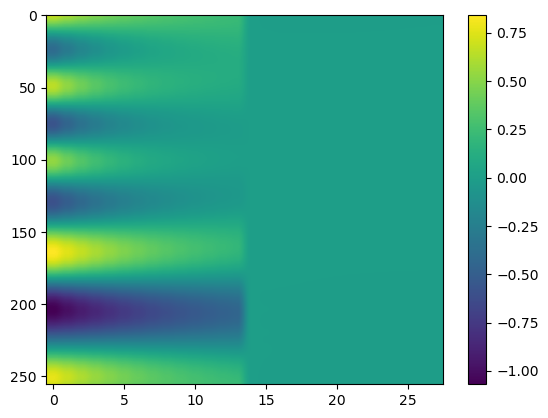

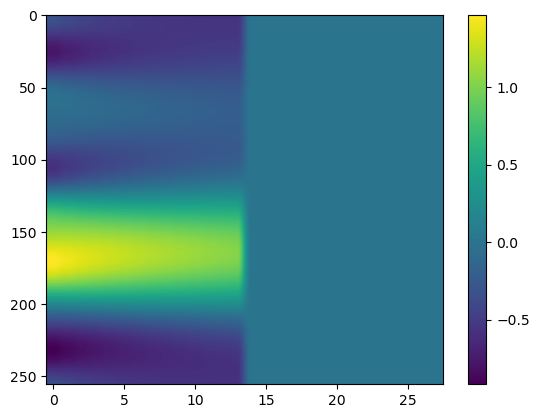

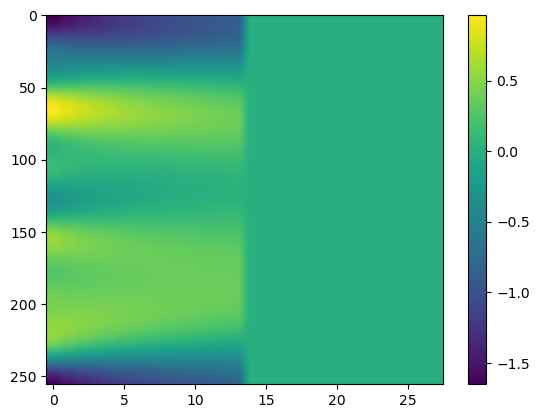

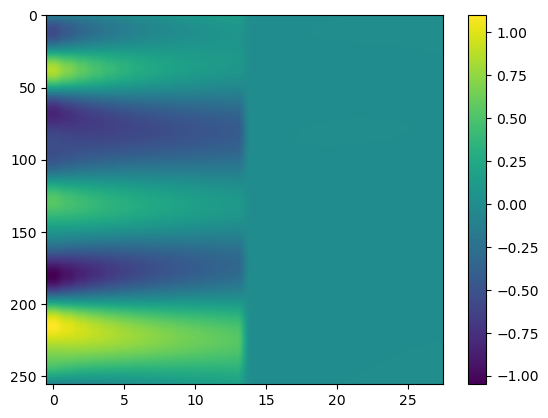

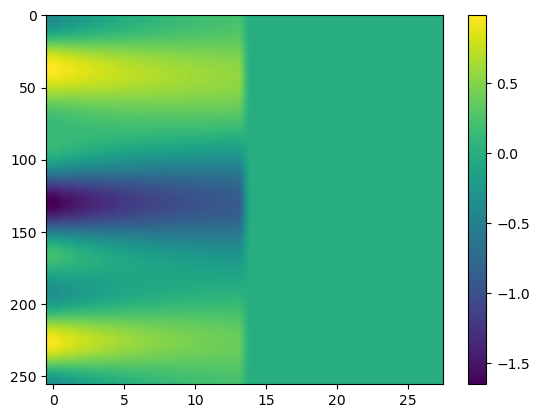

In [8]:
for idx in range(10):
    plt.figure()
    plt.imshow(torch.cat([test_Y[idx].T, test_Y[idx].T - pred[idx].T], dim=1), aspect='auto')
    plt.colorbar()

# plt.figure()
# plt.imshow(, aspect='auto')
# plt.colorbar()